# Prep

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/github_drive/code

/content/drive/My Drive/github_drive/code


## Install sktime

In [3]:
!pip install sktime

## Save Weights functions: input as 2d numpy array

In [4]:
def save_weight(model, test_data, labels, predicted, ds):
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(predicted)
        new_predicted = le.transform(predicted)
        weights = np.empty(dtype=float, shape=(0,test_data.shape[1]))
        
        # print('   Original    predicted class: ', np.unique(predicted))
        # print('   Transformed predicted class: ', np.unique(new_predicted))
        
        
        for i, ts in enumerate(test_data):
            w = model.map_sax_model(ts)
            pred_class = int(new_predicted[i])
            w = [w[pred_class]]
            
            weights = np.append(weights, w, axis = 0)
        fileName = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
        np.savetxt(fileName, weights, delimiter=",")

# Get Explanation weights - Mr-SEQL

## Import Libraries

In [12]:
import os
import numpy as np
from sklearn import metrics


from sktime.classification.shapelet_based import MrSEQLClassifier

In [11]:
ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_dir = 'data'


## Train the Classifier with Mr-SEQL & save explanation weights

In [7]:

for ds in ds_list:
    print('Dataset %s' %ds)
    train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')

    # load train data
    train_data = np.genfromtxt(train_file,delimiter=',')
    train_x = np.expand_dims(train_data[:,1:], 1)
    train_y = train_data[:,0]
    
    ms = MrSEQLClassifier(seql_mode="fs")
    ms.fit(train_x,train_y)
    
    # load test data
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x = np.expand_dims(test_data[:,1:], 1)
    test_y = test_data[:,0]

    # # prediction
    predicted = ms.predict(test_x)

    # Classification accuracy
    print("Accuracy with mr-seql: %2.4f" % metrics.accuracy_score(test_y, predicted))
    
    # Reload Test data as 2D array numpy format:
    test_x = test_data[:,1:]
    save_weight(model = ms, test_data = test_x, labels = test_y, predicted = predicted, ds = ds)
    print('DONE. weight_saved. ')
   

Dataset CBF
Accuracy with mr-seql: 0.9989
DONE. weight_saved. 
Dataset CMJ
Accuracy with mr-seql: 0.9609
DONE. weight_saved. 
Dataset Coffee
Accuracy with mr-seql: 1.0000
DONE. weight_saved. 
Dataset ECG200
Accuracy with mr-seql: 0.8500
DONE. weight_saved. 
Dataset GunPoint
Accuracy with mr-seql: 0.9867
DONE. weight_saved. 


# Visualize Explanation Weights


## Define Function

In [35]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.interpolate import interp1d

def visualize_example(example_idx, explanation_weight , ds = 'CMJ'):
    idx = example_idx
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x, test_y  = test_data[:,1:], test_data[:,0]

    le = preprocessing.LabelEncoder()
    le.fit(test_y)
    transformed_test_y = le.transform(test_y)
    n_class = np.unique(transformed_test_y).shape[0]
    
    def transform(X):
        ma,mi = np.max(X), np.min(X)
        X = (X - mi)/(ma-mi)
        return X*100
    weight = abs(explanation_weight[idx])
    weight = transform(weight)
    ts = test_x[idx]
    
    
    max_length1, max_length2 = len(ts),10000 #
    x1 = np.linspace(0,max_length1,num = max_length1)
    x2 = np.linspace(0,max_length1,num = max_length2)
    y1 = ts
    
    f = interp1d(x1, y1) # interpolate time series
    fcas = interp1d(x1, weight) # interpolate weight color
    weight = fcas(x2) # convert vector of original weight vector to new weight vector

    plt.scatter(x2,f(x2), c = weight, cmap = 'jet', marker='.', s= 1,vmin=0,vmax = 100)
    plt.xlabel('Explanation for index %d, dataset %s' %(example_idx, ds))
    plt.show()



def get_explanation_weight(explanation_method, ds):
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x, test_y  = test_data[:,1:], test_data[:,0]
    
    if explanation_method == 'MrSEQL-SM':        explanation_weight_file = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
    elif explanation_method == 'MrSEQL-LIME':    explanation_weight_file = 'output/explanation_weight/weights_LIME_%s.txt' % ds
    elif explanation_method == 'ResNet-CAM':      explanation_weight_file = 'output/resnet_weights/ResNet_%s_BestModel.hdf5_model_weights.txt' % ds
    else: 
        print('ERROR')
    explanation_weight = np.genfromtxt(explanation_weight_file, delimiter = ',')
    if explanation_method =='MrSEQL-LIME': 
        repeat_times = test_x.shape[1]//10
        explanation_weight = np.repeat(explanation_weight, repeat_times).reshape(test_y.shape[0],-1)
#     explanation_weight = abs(explanation_weight)
    return explanation_weight

## Visualize

In [32]:
example_li  =  [18,70,150] # indices of the examples
ds = 'CMJ'
method = 'MrSEQL-SM'
weight = get_explanation_weight(explanation_method=method, ds = ds)


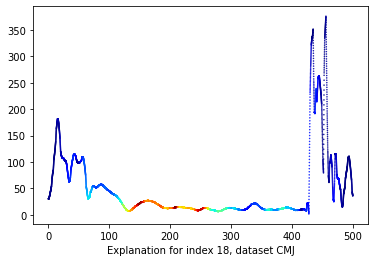

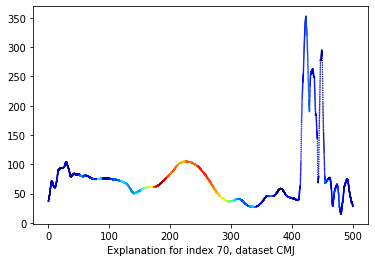

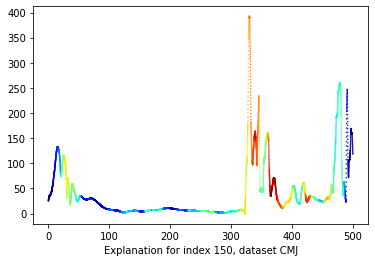

In [36]:
for idx in example_li:
  visualize_example(example_idx= idx, explanation_weight=weight, ds = ds)